# MODELISATION

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import networkx as nx
import sys
import time

from gensim.models.doc2vec import Doc2Vec
from gensim.models import KeyedVectors

import paths

## 1. Load the data

In [2]:
# Read datasets
# Train
train_pairs = pd.read_csv(
    paths.TRAIN_PAIRS_PATH, 
    names=['node_1', 'node_2']
)
train_target = pd.read_csv(
    paths.TRAIN_TARGET_PATH,
    names=['target']
).to_numpy().ravel()

# Test
test_pairs = pd.read_csv(
    paths.TEST_PAIRS_PATH,
    names=['node_1', 'node_2']
)
test_target = pd.read_csv(
    paths.TEST_TARGET_PATH,
    names=['target']
).to_numpy().ravel()

# For the Kaggle challenge
challenge_pairs = pd.read_csv(
    paths.CHALLENGE_PAIRS_PATH,
    names=['node_1', 'node_2']
)

In [3]:
# Load the training graph
train_graph = nx.read_edgelist(
    paths.TRAIN_EDGELIST_PATH, delimiter=',', nodetype=int
)

# Load the test graph
test_graph = nx.read_edgelist(
    paths.TEST_EDGELIST_PATH, delimiter=',', nodetype=int
)

# Load the full graph
full_graph = nx.read_edgelist(
    paths.FULL_GRAPH_EDGELIST_PATH, delimiter=',', nodetype=int
)

In [4]:
# Read the abstract of each paper
abstracts = dict()
with open(paths.ABSTRACTS_PATH, 'r') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts[int(node)] = abstract

# Read the authors to each paper
authors = dict()
with open(paths.PAPER_2_AUTHORS_ID_PATH, 'r') as f:
    for line in f:
        node, node_authors = line.rstrip('\n').split('|--|')
        authors[int(node)] = node_authors.split(',')


In [5]:
# Read the Doc2vec model
doc2vec_model = Doc2Vec.load(paths.DOC2VEC_PATH)

# Read nodes embeddings
node2vec_train = KeyedVectors.load_word2vec_format(paths.NODE2VEC_TRAIN_PATH)
node2vec_test = KeyedVectors.load_word2vec_format(paths.NODE2VEC_TEST_PATH)
node2vec_full_graph = KeyedVectors.load_word2vec_format(paths.NODE2VEC_FULL_GRAPH_PATH)

## 2. Function to compute the features

### 2.1. Semantic Features

####  Cosine similarity of abstract embeddings

In [7]:
def cosine_similarity_doc2vec(paper_1, paper_2):
    """
    Computes the cosine similarity between the abstract embeddings of two papers/nodes.
    """
    # The model was trained on all the papers 
    return doc2vec_model.docvecs.similarity(paper_1, paper_2)

### 2.2. Attribute Features

#### Number of common authors

In [8]:
def common_authors(paper_1, paper_2):
    """
    Computes the number of common author between two papers/nodes.
    """
    # The model was trained on all the papers 
    return len(set(authors[paper_1]) & set(authors[paper_2]))

### 2.2. Graph based features

#### Degree approches

In [9]:
def abs_diff_degree(node_1, node_2, G):
    """
    Computes the difference in degree of two nodes in a graph.
    """
    return abs(G.degree(node_1) - G.degree(node_2))


def sum_degree(node_1, node_2, G):
    """
    Computes the difference in degree of two nodes in a graph.
    """
    return G.degree(node_1) + G.degree(node_2)

#### Local based similarity measures

In [10]:
def jaccard_coefficient(node_1, node_2, G):
    """
    Computes the jaccard coefficient of two nodes in a graph.
    """
    _, _, coeff = list(nx.jaccard_coefficient(G, [(node_1, node_2)]))[0]
    return coeff


def adamic_adar_index(node_1, node_2, G):
    """
    Computes the adamic adar index of two nodes in a graph.
    """
    _, _, index = list(nx.adamic_adar_index(G, [(node_1, node_2)]))[0]
    return index


def pref_attachment(node_1, node_2, G):
    """ 
    Computes the preferential attachment of two nodes in a graph.
    """
    _, _, p = list(nx.preferential_attachment(G, [(node_1, node_2)]))[0]
    return p


def salton_index(node_1, node_2, G):
    """ 
    Computes the salton index of two nodes in a graph
    """
    sqrt_prod = np.sqrt(G.degree(node_1) * G.degree(node_1))
    if sqrt_prod == 0:
        return 0
    return len(list(nx.common_neighbors(G, node_1, node_2))) / sqrt_prod

#### Global based similarity measures

In [11]:
def shortest_path_length(node_1, node_2, G):
    """
    Computes the shortest path length between two nodes in a graph.
    """
    try:
        length = nx.shortest_path_length(G, node_1, node_2)
    except nx.NetworkXNoPath:
        length = -1
    return length


def diff_pagerank(node_1, node_2, pageranks):
    """ 
    Computes the absolute difference in the pageranks of two nodes in a graph
    """
    return np.abs(pageranks[node_1] - pageranks[node_2])


def diff_eigvec_centrality(node_1, node_2, eigvec_centrality):
    """ 
    Computes the absolute difference in the eigenvector centrality of two nodes in a graph
    """
    return np.abs(eigvec_centrality[node_1] - eigvec_centrality[node_2])


def diff_bet_centrality(node_1, node_2, bet_centrality):
    """ 
    Computes the absolute difference in the betweeness centrality of two nodes in a graph
    """
    return np.abs(bet_centrality[node_1] - bet_centrality[node_2])

## 3. Computing features

In [28]:
X_train = train_pairs.copy()
X_test = test_pairs.copy()
X_challenge = challenge_pairs.copy()

In [34]:
def compute_features(df, G, name):
    print(f"Computing features for the {name} set")
    print('-'*50)

    t0 = time.time()
    df["n_common_authors"] = df.apply(
        lambda row: common_authors(row['node_1'], row['node_2']),
        axis=1
    )
    print(f"n_common_authors - done [{round(time.time() - t0,1)}s]")

    t1 = time.time()
    df["abstract_similarity"] = df.apply(
        lambda row: cosine_similarity_doc2vec(row['node_1'], row['node_2']),
        axis=1
    )
    print(f"abstract_similarity - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["abs_diff_degree"] = df.apply(
        lambda row: abs_diff_degree(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"abs_diff_degree - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["sum_degree"] = df.apply(
        lambda row: sum_degree(row['node_1'], row['node_2'], G),
        axis=1
    ) 
    print(f"sum_degree - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["jaccard_coeff"] = df.apply(
        lambda row: jaccard_coefficient(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"jaccard_coeff - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["adamic_adar_index"] = df.apply(
        lambda row: adamic_adar_index(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"adamic_adar_index - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["pref_attachment"] = df.apply(
        lambda row: pref_attachment(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"pref_attachment - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["salton_index"] = df.apply(
        lambda row: salton_index(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"salton_index - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    df["shortest_path_length"] = df.apply(
        lambda row: shortest_path_length(row['node_1'], row['node_2'], G),
        axis=1
    )
    print(f"shortest_path_length - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    eigvec_centrality = nx.eigenvector_centrality(G)
    df["diff_eigvec_centrality"] = df.apply(
        lambda row: diff_eigvec_centrality(
            row['node_1'], row['node_2'], eigvec_centrality
        ), axis=1
    )
    print(f"diff_eigvec_centrality - done [{round(time.time() - t1,1)}s]")

    t1 = time.time()
    pageranks = nx.pagerank(G)
    df["diff_pagerank"] = df.apply(
        lambda row: diff_pagerank(
            row['node_1'], row['node_2'], pageranks
        ), axis=1
    )
    t2 = time.time()
    print(f"diff_pagerank - done [{round(t2 - t1,1)}s]")
    print(f"Total time : [{round(t2 - t0,1)}s]")


In [35]:
compute_features(X_train, train_graph, 'train')
X_train.to_csv(paths.TRAIN_FEATS_PATH, index=False)

compute_features(X_test, test_graph, 'test')
X_test.to_csv(paths.TEST_FEATS_PATH, index=False)

compute_features(X_challenge, full_graph, 'challenge')
X_challenge.to_csv(paths.CHALLENGE_FEATS_PATH, index=False)


Computing features for the test set
--------------------------------------------------
n_common_authors - done [6.3s]
abstract_similarity - done [14.4s]
abs_diff_degree - done [8.6s]
sum_degree - done [6.6s]
jaccard_coeff - done [54.7s]
adamic_adar_index - done [46.9s]
pref_attachment - done [13.7s]
salton_index - done [52.4s]
shortest_path_length - done [116.9s]
diff_eigvec_centrality - done [23.8s]
diff_pagerank - done [10.8s]
Total time : [355.0s]
Computing features for the challenge set
--------------------------------------------------
n_common_authors - done [2.2s]
abstract_similarity - done [4.4s]
abs_diff_degree - done [2.0s]
sum_degree - done [1.9s]
jaccard_coeff - done [21.9s]
adamic_adar_index - done [15.8s]
pref_attachment - done [1.9s]
salton_index - done [15.1s]
shortest_path_length - done [30.4s]
diff_eigvec_centrality - done [25.1s]
diff_pagerank - done [7.5s]
Total time : [128.2s]


## 4. Add Link embeddings

Since we have the node/paper embeddings, we have to compute a link embedding because our datasets contain link (pairs of nodes). We define the following operators to do so

In [6]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

### Link topological embeddings

In [7]:
def get_node_embedding(node, node_vectors):
    """
    Get the embedding of a node from node2vec model.
    """
    return node_vectors[str(node)]


def link_graph_embedding(link_examples, node_vectors, binary_operator):
    return [
        binary_operator(
            get_node_embedding(node_1, node_vectors),
            get_node_embedding(node_2, node_vectors)
        )
        for node_1, node_2 in link_examples
    ]


### Link semantic embeddings

In [8]:
def get_semantic_embedding(node, model):
    """
    Get the embedding of a node from node2vec model.
    """
    return model.docvecs[node]


def link_semantic_embedding(link_examples, binary_operator, model=doc2vec_model):
    return [
        binary_operator(
            get_semantic_embedding(paper_1, model),
            get_semantic_embedding(paper_2, model)
        )
        for paper_1, paper_2 in link_examples
    ]


## 5. Model

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, log_loss, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

In [16]:
# Read datasets
X_train = pd.read_csv(paths.TRAIN_FEATS_PATH)
train_target = pd.read_csv(paths.TRAIN_TARGET_PATH, header=None).to_numpy().ravel()

X_test = pd.read_csv(paths.TEST_FEATS_PATH)
test_target = pd.read_csv(paths.TEST_TARGET_PATH, header=None).to_numpy().ravel()

X_challenge = pd.read_csv(paths.CHALLENGE_FEATS_PATH)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
X_train.drop(columns=['node_1', 'node_2', 'sum_degree', 'diff_pagerank'], inplace=True)
X_test.drop(columns=['node_1', 'node_2', 'sum_degree', 'diff_pagerank'], inplace=True)
X_challenge.drop(columns=['node_1', 'node_2', 'sum_degree', 'diff_pagerank'], inplace=True)

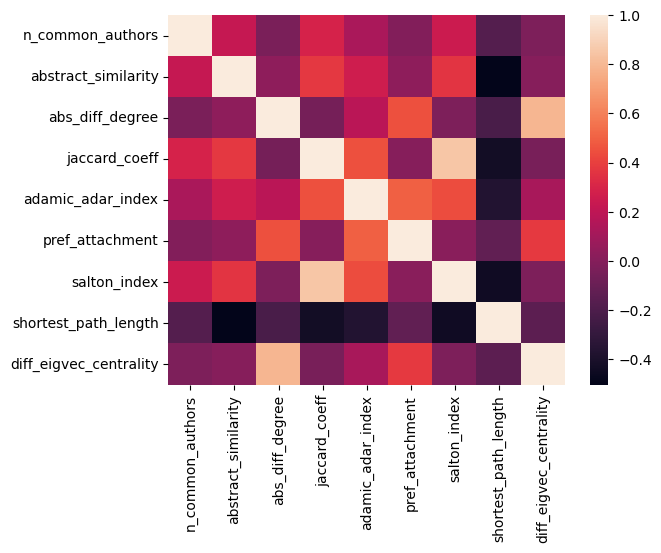

In [18]:
sns.heatmap(X_train.corr())
plt.show()

### Add the corresponding link embedding

In [19]:
X_train_graph_emb = link_graph_embedding(
    train_pairs.to_numpy(),
    node2vec_train,
    binary_operator=operator_l1
)
X_train_sem_emb = link_semantic_embedding(
    train_pairs.to_numpy(),
    binary_operator=operator_l1
)

X_train_c = np.concatenate(
    (X_train.to_numpy(), np.array(X_train_graph_emb), np.array(X_train_sem_emb)),
    axis=1
)
print("Shape of X_train:", X_train_c.shape)

Shape of X_train: (349424, 201)


In [20]:
X_test_graph_emb = link_graph_embedding(
    test_pairs.to_numpy(),
    node2vec_test,
    binary_operator=operator_l1
)
X_test_sem_emb = link_semantic_embedding(
    test_pairs.to_numpy(),
    binary_operator=operator_l1
)

X_test_c = np.concatenate(
    (X_test.to_numpy(), np.array(X_test_graph_emb), np.array(X_test_sem_emb)),
    axis=1
)
print("Shape of X_test:", X_test_c.shape)

Shape of X_test: (436782, 201)


In [21]:
X_challenge_graph_emb = link_graph_embedding(
    challenge_pairs.to_numpy(),
    node2vec_full_graph,
    binary_operator=operator_l1
)
X_challenge_sem_emb = link_semantic_embedding(
    challenge_pairs.to_numpy(),
    binary_operator=operator_l1
)

X_challenge_c = np.concatenate(
    (X_challenge.to_numpy(), np.array(X_challenge_graph_emb), np.array(X_challenge_sem_emb)),
    axis=1
)
print("Shape of X_challenge:", X_challenge_c.shape)

Shape of X_challenge: (106692, 201)


In [22]:
X_new_c = np.concatenate((X_train_c, X_test_c))
y_new = np.concatenate((train_target, test_target))

In [27]:
scaler = StandardScaler()
X_new_sc = scaler.fit_transform(X_new_c)
X_challenge_sc = scaler.transform(X_challenge_c)

lr_clf = XGBClassifier(
    sub_sample=0.8,learning_rate = 0.2,colsample_bytree=0.6,max_depth=5,
    n_estimators=100,min_child_weight=5,gamma=5
)
lr_clf.fit(X_new_sc, y_new)

/Users/kevinab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [23]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_c)
X_test_sc = scaler.transform(X_test_c)
X_challenge_sc = scaler.transform(X_challenge_c)

lr_clf = LogisticRegression()
lr_clf.fit(X_train_sc, train_target)

LogisticRegression()

In [25]:
log_loss(y_new, lr_clf.predict_proba(X_new_sc)[:,1])

0.10884700054453772

In [26]:
log_loss(train_target, lr_clf.predict_proba(X_train_sc)[:,1])

0.13854605082428664

In [24]:
log_loss(test_target, lr_clf.predict_proba(X_test_sc)[:,1])

0.13537734135616686

In [25]:
roc_auc_score(test_target, lr_clf.predict_proba(X_test_sc)[:,1])

0.9892584362952432

In [63]:
recall_score(test_target, lr_clf.predict(X_test_sc))

0.9601357198785664

In [26]:
import csv
y_pred = lr_clf.predict_proba(X_challenge_sc)
y_pred = y_pred[:,1]

# Write predictions to a file
predictions = zip(range(len(y_pred)), y_pred)
with open("submission.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row) 

In [145]:
X_train.columns

Index(['n_common_authors', 'abstract_similarity', 'jaccard_coeff',
       'adamic_adar_index', 'shortest_path_length', 'abs_diff_degree',
       'sum_degree'],
      dtype='object')

NameError: name 'pd' is not defined

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

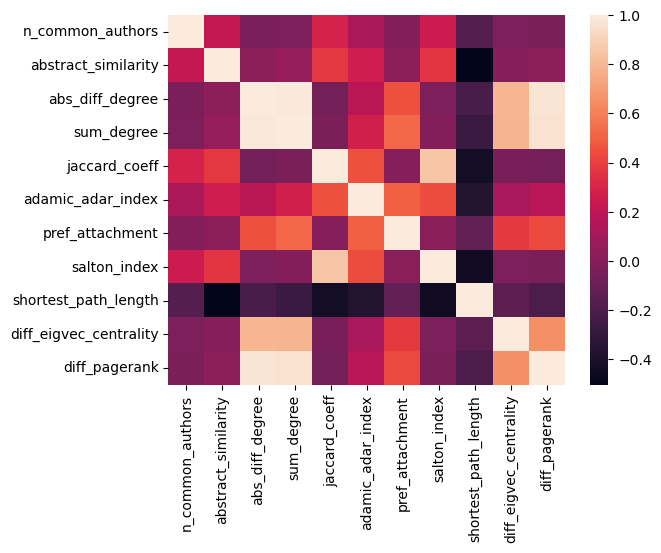

In [34]:
sns.heatmap(X_train.corr())
plt.show()